# Training Deep Neural Networks on a GPU

Importing Libraries

In [1]:
import torch 
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline


matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
dataset = MNIST(root='data/', download=False, transform=ToTensor())

In [3]:
image, label = dataset[0]
image.permute(1, 2, 0).shape

torch.Size([28, 28, 1])

image.shape: torch.Size([1, 28, 28])
label: 5


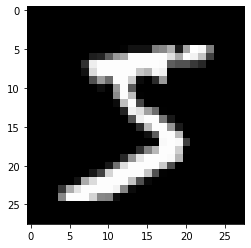

In [4]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')   # plt.imshow expects channels to be last dimension in an image tensor, so we use permute to reorder
print('label:', label)

In [5]:
len(dataset)

60000

dataset[0]

image.shape: torch.Size([1, 28, 28])
label: 2


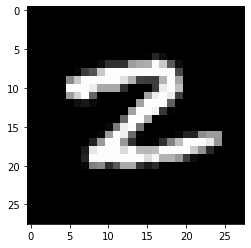

In [6]:
image, label = dataset[143]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')   # plt.imshow expects channels to be last dimension in an image tensor, so we use permute to reorder
print('label:', label)

## validation-set using random_split

In [7]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

## PyTorch data loaders

In [8]:
batch_size = 128

In [9]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

num_workers attribute tells the data loader instance how many sub-processes to use for data loading. By default, the num_workers value is set to zero, and a value of zero tells the loader to load the data inside the main process.

pin_memory (bool, optional) – If True, the data loader will copy tensors into CUDA pinned memory before returning them.


In [10]:
for images, _ in train_loader:
    print('images.shape', images.shape)
    print('grid.shape', make_grid(images, nrow=16).shape)
    break

images.shape torch.Size([128, 1, 28, 28])
grid.shape torch.Size([3, 242, 482])


image.shape: torch.Size([1, 28, 28])


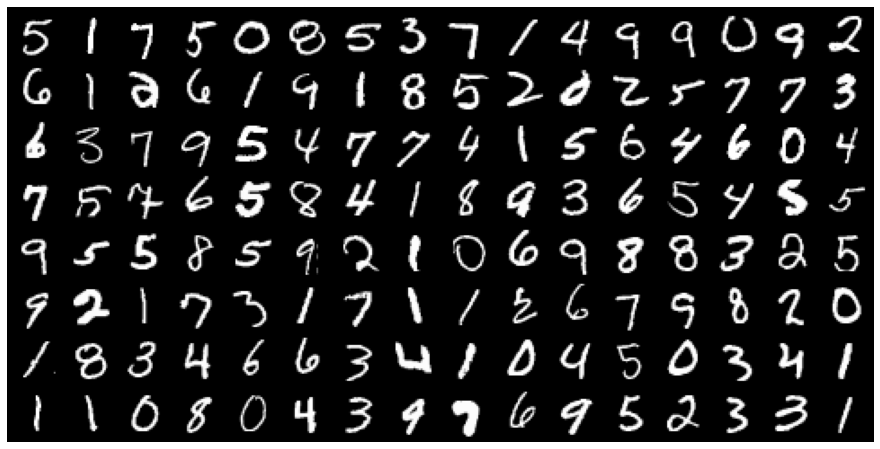

In [11]:
# visualize a batch of data using grid

for images, _ in train_loader:
    print('image.shape:', image.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Creating NN

Hidden Layers, Activation function and Non-Linearity

In [12]:
# creating a batch of input tensors

for images, labels in train_loader:
    print('images.shape', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape', inputs.shape)
    break

images.shape torch.Size([128, 1, 28, 28])
inputs.shape torch.Size([128, 784])


In [13]:
# from Hidden layer using nn.Linear Layer

input_size = inputs.shape[-1]

#size of output from hidden layer is 32, can be inc or dec to change the learning capacity of model

hidden_size = 32

In [14]:
layer1 = nn.Linear(input_size, hidden_size ) # it will convert 784 to 32

In [15]:
inputs.shape

torch.Size([128, 784])

In [16]:
layer1_outputs = layer1(inputs)
print('layer1_outputs', layer1_outputs.shape)

layer1_outputs torch.Size([128, 32])


In [17]:
# Direct matrix computation

layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [18]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

Thus, `layer1_outputs` and `inputs` have a linear relationship, i.e., each element of `layer_outputs` is a weighted sum of elements from `inputs`. Thus, even as we train the model and modify the weights, `layer1` can only capture linear relationships between `inputs` and `outputs`.

<img src="https://c.mql5.com/18/20/NN1__1.gif">



Next, we'll use the Rectified Linear Unit (ReLU) function as the activation function for the outputs. It has the formula `relu(x) = max(0,x)` i.e. it simply replaces negative values in a given tensor with the value 0. ReLU is a non-linear function, as seen here visually:

<img src="https://i.imgur.com/yijV4xF.png" width="420">

We can use the `F.relu` method to apply ReLU to the elements of a tensor.

In [19]:
 F.relu(torch.tensor([[1, -1, 0],
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

In [20]:
layer1_outputs.shape

torch.Size([128, 32])

In [21]:
# apply the activation function to layer1_outputs

relu_outputs =  F.relu(layer1_outputs)
print('relu_outputs.shape:', relu_outputs.shape)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

relu_outputs.shape: torch.Size([128, 32])
min(layer1_outputs): -0.6917587518692017
min(relu_outputs): 0.0


In [22]:
# creating output layer to convert vectors into 10 target label size 

output_size = 10

layer2 = nn.Linear(hidden_size, output_size)


In [23]:
# pass relu_outputs to layer2 to obtain relu_outputs

layer2_outputs = layer2(relu_outputs)

print('relu_outputs.shape:', relu_outputs.shape)

print('layer2_outputs.shape:', layer2_outputs.shape)

relu_outputs.shape: torch.Size([128, 32])
layer2_outputs.shape: torch.Size([128, 10])


In [24]:
inputs.shape

torch.Size([128, 784])

In [25]:
# now we can use this outputs to compute the loss using F.cross_entropy and adjust weights of layer1 and layer2 using gradient descent 

F.cross_entropy(layer2_outputs, labels)

tensor(2.2991, grad_fn=<NllLossBackward>)

In [26]:
# to verify linearity in layer 1 and non-linearity in layer 2  using re-computing the output using basic matrix operations

outputs = (F.relu(inputs @ layer1.weight.t() +layer1.bias)) @ layer2.weight.t() + layer2.bias

In [27]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

if we hadn't included a non-linear activation between the two linear layers, the final relationship b/w inputs and outputs would be Linear 

In [28]:
# implementing -->  layer2(layer1(inputs))

outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias 

In [29]:
# create a single layer to replace two linear layers

combined_layer = nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [30]:
# implementation of combined_layer(inputs)

outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [31]:
torch.allclose(outputs2, outputs3, 1e-3)

False

## Model

We are now ready to define our model. As discussed above, we'll create a neural network with one hidden layer. Here's what that means:

* Instead of using a single `nn.Linear` object to transform a batch of inputs (pixel intensities) into outputs (class probabilities), we'll use two `nn.Linear` objects. Each of these is called a _layer_ in the network. 

* The first layer (also known as the hidden layer) will transform the input matrix of shape `batch_size x 784` into an intermediate output matrix of shape `batch_size x hidden_size`. The parameter `hidden_size` can be configured manually (e.g., 32 or 64).

* We'll then apply a non-linear *activation function* to the intermediate outputs. The activation function transforms individual elements of the matrix.

* The result of the activation function, which is also of size `batch_size x hidden_size`, is passed into the second layer (also known as the output layer).  The second layer transforms it into a matrix of size `batch_size x 10`. We can use this output to compute the loss and adjust weights using gradient descent.


As discussed above, our model will contain one hidden layer. Here's what it looks like visually:

<img src="https://i.imgur.com/eN7FrpF.png" width="480">


Let's define the model by extending the `nn.Module` class from PyTorch.

In [32]:
class MnistModel(nn.Module):
    
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        
        self.Linear1 = nn.Linear(in_size, hidden_size)  # hidden layer
        self.Linear2 = nn.Linear(hidden_size, out_size) # output layer
        
        
    def forward(self, xb):
        
        xb = xb.view(xb.size(0),-1) # flatten image tensor
         
        out = self.Linear1(xb)      # intermediate outputs using hidden layer
        out = F.relu(out)           # applying activation function
        out = self.Linear2(out)     # predictions using o/p layer
        
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()   # Combine losses
        
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # combine accuracies
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:4f}, val_acc: {:4f}".format(epoch, result['val_loss'], result['val_acc']))
        

In [33]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [34]:
# creating a model of hidden layers with 32 activations

input_size = 784
hidden_size = 32
num_classes = 10

In [35]:
model = MnistModel(input_size, hidden_size, out_size = num_classes) 

In [36]:
# model's parameters

for t in model.parameters():                   # weights and bias for linear layer and hidden layer
    print(t.shape)                       

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [37]:
# generate some outputs using our model

for images, labels in train_loader:
    outputs = model(images)
    break
    
loss = F.cross_entropy(outputs, labels)
print('Loss:', loss.item())    
print('outputs.shape: ', outputs.shape)
print('Sample outputs :', outputs[:2].data)

Loss: 2.3032402992248535
outputs.shape:  torch.Size([128, 10])
Sample outputs : tensor([[ 0.0308,  0.1783, -0.0268, -0.1578, -0.1123, -0.0013,  0.1285, -0.0645,
         -0.0745, -0.0817],
        [-0.0028,  0.2039, -0.0196, -0.1190, -0.1853,  0.0436,  0.0258,  0.0813,
         -0.1292, -0.0431]])


## Training the Model using GPU

In [38]:
torch.cuda.is_available()

True

In [39]:
# code to ensure our model uses GPU if available and default CPU

def get_default_device():
    
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [40]:
device = get_default_device()
device

device(type='cuda')

In [41]:
# function that can move data and model to chosen device

def to_device(data, device):
    """MOve tensors to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)       # to method 

In [42]:
for images, labels in train_loader:
    print(images.shape)
    print(images.device)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cpu
cuda:0


DeviceDataLeader class to wrap our existing data loaders and move batches of data to the selected device, __iter__ method to retrieve batches of data and an __len__ to get number of batches

In [43]:
class DeviceDataLoader():
                                         # wrap a dataloader to move data to device
    def __init__(self, dl , device):
        self.dl = dl
        self.device = device
                                         # yield a batch of data after moving it to device
    def __iter__(self):
        
        for b in self.dl:
            yield to_device(b, self.device) 
                                               # number of batches
    def __len__(self):
        
        return len(self.dl)
        

In [44]:
# yield --> create a generator function that can be used within a for loop 

# example

def some_numbers():
    yield 10
    yield 20 
    yield 30
    
for value in some_numbers():
    print(value)

10
20
30


In [45]:
# wrap data loaders using DeviceDataLoader

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [46]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([1, 4, 3, 7, 8, 2, 2, 2, 0, 1, 3, 7, 1, 2, 7, 6, 5, 2, 7, 6, 4, 6, 3, 0,
        3, 7, 2, 1, 5, 1, 5, 0, 6, 0, 7, 1, 9, 3, 5, 6, 6, 6, 3, 1, 2, 7, 0, 1,
        7, 4, 3, 9, 7, 2, 1, 4, 3, 4, 8, 3, 1, 0, 9, 6, 4, 0, 2, 5, 2, 6, 7, 4,
        4, 6, 7, 3, 4, 0, 0, 2, 5, 5, 5, 5, 0, 9, 4, 3, 9, 6, 0, 4, 8, 6, 2, 8,
        1, 7, 8, 2, 4, 4, 6, 6, 7, 0, 7, 4, 0, 1, 1, 9, 4, 0, 9, 2, 4, 2, 8, 6,
        7, 1, 5, 3, 7, 8, 4, 2, 6, 8, 1, 7, 3, 8, 4, 4, 7, 9, 7, 2, 9, 6, 8, 7,
        9, 4, 3, 5, 1, 9, 8, 9, 1, 3, 9, 6, 9, 9, 9, 9, 7, 4, 3, 3, 1, 2, 7, 8,
        5, 8, 0, 8, 3, 1, 6, 3, 1, 0, 6, 6, 1, 5, 4, 7, 9, 4, 5, 4, 2, 3, 3, 2,
        9, 6, 6, 3, 8, 4, 4, 2, 1, 7, 7, 3, 4, 5, 8, 2, 9, 9, 6, 8, 7, 6, 0, 6,
        0, 0, 1, 1, 1, 4, 0, 9, 5, 2, 0, 3, 0, 0, 0, 4, 7, 9, 6, 0, 3, 4, 5, 6,
        0, 0, 9, 7, 8, 6, 3, 0, 7, 8, 7, 7, 4, 0, 8, 0], device='cuda:0')


Training part

In [47]:
def evaluate(model, val_loader):
    
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        #training phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        #validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history


In [48]:
# Model(on GPU)

model = MnistModel(input_size, hidden_size= hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (Linear1): Linear(in_features=784, out_features=32, bias=True)
  (Linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [49]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.309469223022461, 'val_acc': 0.12490234524011612}]

In [50]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.202114, val_acc: 0.941016
Epoch [1], val_loss: 0.156000, val_acc: 0.953223
Epoch [2], val_loss: 0.156326, val_acc: 0.953516
Epoch [3], val_loss: 0.127720, val_acc: 0.962598
Epoch [4], val_loss: 0.119708, val_acc: 0.962793


try with more less lr 

In [51]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.109468, val_acc: 0.967578
Epoch [1], val_loss: 0.105522, val_acc: 0.968164
Epoch [2], val_loss: 0.105320, val_acc: 0.969824
Epoch [3], val_loss: 0.104688, val_acc: 0.969629
Epoch [4], val_loss: 0.104357, val_acc: 0.968555


## Lmao acc ~ 96%

Text(0.5, 1.0, 'Loss v/s Epochs')

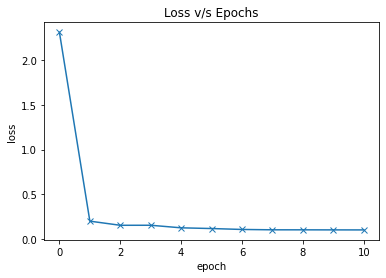

In [52]:
# plot losses and accuracies

losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss v/s Epochs')

Text(0.5, 1.0, 'Accuracies v/s Epochs')

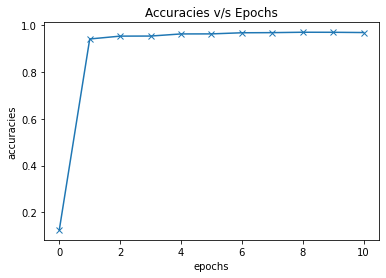

In [53]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epochs')
plt.ylabel('accuracies')
plt.title('Accuracies v/s Epochs')

## Testing with Individual Images

In [54]:
test_dataset = MNIST(root='data/',
                     train=False, 
                     transform=ToTensor())

In [63]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    print(xb.device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

cuda:0
Label: 7 Prediction: 7


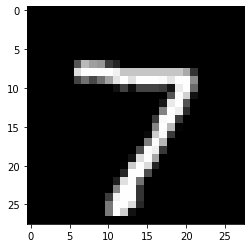

In [64]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, 'Prediction:', predict_image(img, model))

cuda:0
Label: 6 Prediction: 6


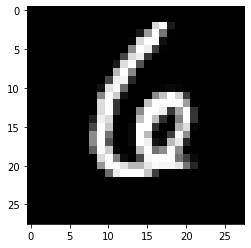

In [65]:
img, label = test_dataset[123]
plt.imshow(img[0], cmap='gray')
print('Label:', label, 'Prediction:', predict_image(img, model))

cuda:0
Label: 0 Prediction: 0


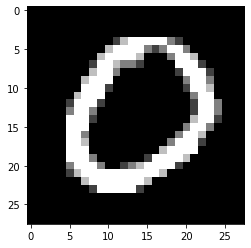

In [66]:
img, label = test_dataset[183]
plt.imshow(img[0], cmap='gray')
print('Label:', label, 'Prediction:', predict_image(img, model))

In [68]:
# overall loss and accuracy of model on training set

test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.10134970396757126, 'val_acc': 0.9697265625}

In [69]:
# saving the model

torch.save(model.state_dict(), 'mnist-feedforward.pth')